In [1]:
import requests 
import json 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import time
from glob import glob
import numpy as np
import os
import pickle
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns

In [2]:
import sys
sys.path.append("/shared/script")
import warnings
warnings.filterwarnings("ignore")
import Franklin_Utility

Crypto research demo code, Franklin Chi, minghao.chi.baruch.mfe@gmail.com

To make codes more readable, I wrapped backtest functions in Franklin_Utility.py

# Contents:

## Part 0, research framework set up
* 0.1 time measurement rules
* 0.2 data screening and general introduction


## Part 1, alternative data alpha generation using crypto options
* 1.1 option related feature generation
* 1.2 alpha generation and backtesting
* 1.3 holding period research


## Part 2, machine learning for signal combinations
* 2.1 OLS
* 2.2 Lasso

In [3]:
alldata = pd.read_parquet(r'/data/alldata/crypto_perpetual/alldata_hourly.parquet')
alldata = alldata[alldata.symbol == "BTCUSDT"]

In [4]:
alldata

,date,open_time,open,high,low,close,volume,close_time,usdt_volume,num_trades,...,vwap_10m,vwap_5m,close_1m,fret_1m,fret_5m,fret_10m,fret_15m,fret_20m,fret_30m,fret_60m
1,2020-01-01 00:00:00,2019-12-31 23:00:00,7195.04,7199.98,7179.26,7189.00,2037.547,2019-12-31 23:59:59.999,1.464969e+07,3152,...,7191.197564,7192.410484,7197.53,-0.001487,-0.000456,-0.000068,0.000080,0.000250,0.002197,0.003580
4,2020-01-01 01:00:00,2020-01-01 00:00:00,7189.43,7190.52,7170.15,7171.55,2449.049,2020-01-01 00:59:59.999,1.757642e+07,3688,...,7179.553592,7179.557265,7182.44,0.005695,0.005145,0.004750,0.004443,0.004413,0.003543,0.003115
7,2020-01-01 02:00:00,2020-01-01 01:00:00,7171.43,7225.00,7171.10,7210.24,3865.038,2020-01-01 01:59:59.999,2.783805e+07,6635,...,7179.067106,7176.282708,7171.76,0.003585,0.002695,0.002062,0.002022,0.001993,0.001205,0.000180
10,2020-01-01 03:00:00,2020-01-01 02:00:00,7210.38,7239.30,7206.46,7237.99,3228.365,2020-01-01 02:59:59.999,2.332481e+07,5120,...,7213.168259,7213.203968,7212.60,-0.002559,-0.001409,-0.000748,-0.000918,-0.001162,-0.001449,-0.001090
13,2020-01-01 04:00:00,2020-01-01 03:00:00,7237.41,7239.74,7215.00,7221.65,2513.307,2020-01-01 03:59:59.999,1.816182e+07,4143,...,7228.044600,7232.640162,7238.46,-0.000553,-0.000493,-0.000361,0.000080,0.000198,0.000167,0.000020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612030,2023-09-05 23:00:00,2023-09-05 22:00:00,25720.80,25762.10,25712.70,25756.80,2225.771,2023-09-05 22:59:59.999,5.729350e+07,29989,...,25717.927577,25717.158149,25720.80,0.000509,0.000415,0.001129,0.001280,0.001114,0.000966,0.000519
3612229,2023-09-06 00:00:00,2023-09-05 23:00:00,25756.70,25792.40,25753.80,25779.70,2899.821,2023-09-05 23:59:59.999,7.474001e+07,36964,...,25759.214922,25759.885548,25759.70,0.001020,0.000931,0.000181,0.000217,0.000203,0.000324,0.000115
3612428,2023-09-06 01:00:00,2023-09-06 00:00:00,25779.70,25812.30,25763.20,25793.00,4762.483,2023-09-06 00:59:59.999,1.228120e+08,50801,...,25788.284655,25770.586432,25772.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3612627,2023-09-06 02:00:00,2023-09-06 01:00:00,25793.00,25819.00,25758.10,25772.00,3182.176,2023-09-06 01:59:59.999,8.206949e+07,45159,...,25792.964199,25794.582543,25799.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part 0, research framework set up

### 0.1 Time Measurement Rules

#### 0.1.1 `bperf_{i}`
Back Performance, Represents the return rate from the close time of `date-i` to the close time of `date`.

#### 0.1.2 `fret_{i}` 
Future Return, Represents the return rate from `date` to `date+{i} minute VWAP` and from `date+1h` to `date+1h+{i} minute VWAP`.

#### 0.1.3 `fperf_{i}`
Future Performance, Based on the definition of `fret`, it represents the return rate from the VWAP of `date+1` to the VWAP of `date+i+1`.

### 0.2 Data Screening and General Introduction

* alldata contains hourly prices and volumns for cryptos, the target is to predict 6/12/24/168 hours vwap to vwap return, depending on holding period of the strategy
* option_trade_data_including_future contains the option trade data downloaded from deribit, the downloader and data cleaning processes are omited with sample file provided
* use option trade data generate predictive signals for future returns

Alpha spoiling...

- **amount \* option price \* direction / delta**  
  For example, if delta is 0.1, the result is equivalent to 10 times the leverage because the smaller the delta, the greater the leverage. Options that are further out of the money (OTM) have smaller deltas and thus greater leverage.  

$$
\text{delta} = \frac{\partial v}{\partial s}, \quad \text{so} \quad \partial s = \frac{\partial v}{\delta}
$$

- **Deep OTM call**  
  This refers to buying a deep out-of-the-money call after many roll-ups. Because it involves buying something inexpensive, it's akin to purchasing multiple small items at the cost of a single larger one.


### 1.1, option related feature generation

Calculate delta, maturities and all related features

In [5]:
option_trade_data = pd.read_csv("option_trade_data_including_future.csv", index_col = 0)

In [6]:
option_trade_data = Franklin_Utility.option_trade_data_field_generation(option_trade_data)

In [7]:
alldata['open_time'] = pd.to_datetime(alldata['open_time'])
alldata['close_time'] = pd.to_datetime(alldata['close_time'])

In [8]:
option_trade_data.head()

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,...,trade_time,open_time,maturity,moneyness,direction_number,dir_amount,days_to_maturity,T,delta,gamma
0,5,97656501,1604027303597,0,0.0380,0.037770,82.71,BTC-25JUN21-36000-C,13493.99,sell,...,2020-10-30 03:08:23,2020-10-30 03:00:00,2021-06-25,0.374833,-1,-1.0,237,0.651696,0.138522,0.000025
1,4,97615779,1604006718888,2,0.0345,0.036013,80.81,BTC-25JUN21-36000-C,13499.00,sell,...,2020-10-29 21:25:18,2020-10-29 21:00:00,2021-06-25,0.374972,-1,-5.2,238,0.652349,0.129966,0.000024
2,3,97615548,1604006189455,1,0.0350,0.036307,81.11,BTC-25JUN21-36000-C,13497.72,sell,...,2020-10-29 21:16:29,2020-10-29 21:00:00,2021-06-25,0.374937,-1,-3.0,238,0.652366,0.131338,0.000024
3,2,97615547,1604006184193,1,0.0350,0.036307,81.11,BTC-25JUN21-36000-C,13497.57,sell,...,2020-10-29 21:16:24,2020-10-29 21:00:00,2021-06-25,0.374933,-1,-4.9,238,0.652366,0.131335,0.000024
4,1,97615515,1604006012539,1,0.0350,0.036334,81.11,BTC-25JUN21-36000-C,13494.08,sell,...,2020-10-29 21:13:32,2020-10-29 21:00:00,2021-06-25,0.374836,-1,-0.1,238,0.652372,0.131253,0.000024


In [9]:
#option会有末日期权，很赚钱，杠杆倍率几千几万的，这里面的大量一定是有信息的， days to maturity = 0是末日期权
option_trade_data_morethan1w = option_trade_data[option_trade_data["days_to_maturity"]>=7]
option_trade_data_lessthan1w = option_trade_data[(option_trade_data["days_to_maturity"]>=1)&(option_trade_data["days_to_maturity"]<=7)]
option_trade_data_lessthan1d = option_trade_data[(option_trade_data["days_to_maturity"]<1)]

#We have some more alphas with EOD and other short dated options, but not shown in this demo

In [10]:
def get_delta_traded(option_trade_data):
    #option_trade_data["delta_traded"] = option_trade_data["amount"]*option_trade_data["delta"]*option_trade_data["index_price"]*option_trade_data["direction_number"]
    option_trade_data["delta_traded"] = option_trade_data["amount"]*option_trade_data["price"]*option_trade_data["direction_number"]/option_trade_data["delta"]
    delta_traded = option_trade_data.groupby(["open_time"])["delta_traded"].sum() 
    delta_traded = delta_traded.rename("delta_traded").reset_index()
    return delta_traded

In [11]:
delta_traded_1w = get_delta_traded(option_trade_data_morethan1w)

In [12]:
alldata = alldata.merge(delta_traded_1w, on = "open_time", how = "left")

### 1.2 alpha generation and backtesting

In [13]:
#smoothing signals and demean
alldata["delta_traded_MA24"] = alldata["delta_traded"].rolling(window = 24, min_periods = 24).mean()
alldata['delta_traded_demean'] = alldata['delta_traded'] - alldata['delta_traded_MA24']

In [14]:
#outlier removals
alldata['delta_traded_demean_clipped'] = alldata['delta_traded_demean']
# 计算上下限的 0.03% 分位数
lower_bound = alldata['delta_traded_demean_clipped'].quantile(0.03)
upper_bound = alldata['delta_traded_demean_clipped'].quantile(0.97)

# 将超出范围的值设为 NaN
alldata.loc[(alldata['delta_traded_demean_clipped'] < lower_bound) | (alldata['delta_traded_demean_clipped'] > upper_bound), 'delta_traded_demean_clipped'] = np.nan

In [15]:
alldata = Franklin_Utility.calcfperf_binance(alldata, 'fret_60m') #calculate the performance by different hours, using 60 min vwap to vwap

In [16]:
# Only backtest from 2021 for liquidity of crypto, build tfilter as below
tfilters = alldata.inuniv

# bucketing the average return after signal appears, the most ideal case is the returns are monotonic among buckets
# as you can see 166 hours gives the best result, so choose 168 as holding period
Franklin_Utility.cgma(alldata[tfilters], cn=['cnt', 'vol', 'adv'], gb=Franklin_Utility.xrank(alldata[tfilters]["delta_traded_demean_clipped"], 10), rmod='fperf', ret_ds=[12,24,48,72,168])

,mygroup,cnt,vol,adv,med_delta_traded_demean_clipped,min_delta_traded_demean_clipped,max_delta_traded_demean_clipped,12,24,48,72,168
0,0.000000,"1,861",0.6%,"580,994,146",-16.277052,-31.698150,-10.919342,-0.114%,-0.176%,-0.163%,-0.297%,-0.626%
1,1.000000,"1,860",0.6%,"567,856,334",-7.770452,-10.914402,-5.776824,-0.165%,-0.137%,-0.249%,-0.367%,-0.314%
2,2.000000,"1,860",0.6%,"552,218,525",-4.365539,-5.771441,-3.159890,-0.056%,-0.007%,-0.006%,-0.053%,-0.146%
3,3.000000,"1,860",0.6%,"552,825,071",-2.140309,-3.159745,-1.269388,0.022%,0.148%,0.269%,0.373%,0.309%
4,4.000000,"1,860",0.6%,"551,633,911",-0.581067,-1.269280,0.055575,0.001%,-0.133%,0.018%,0.235%,-0.049%
5,5.000000,"1,860",0.6%,"545,219,196",0.666378,0.055911,1.335243,0.114%,0.117%,0.017%,0.142%,0.190%
6,6.000000,"1,860",0.6%,"554,715,699",2.097747,1.335737,3.084852,-0.012%,-0.004%,-0.082%,-0.261%,0.080%
7,7.000000,"1,860",0.6%,"559,422,948",4.225454,3.084952,5.744903,0.058%,0.069%,0.008%,-0.027%,0.114%
8,8.000000,"1,860",0.6%,"576,057,160",7.661199,5.745436,10.525807,0.100%,0.231%,0.214%,0.203%,0.740%
9,9.000000,"1,860",0.6%,"581,175,282",15.983436,10.528548,32.432888,0.043%,-0.014%,0.307%,0.538%,1.445%


<AxesSubplot:xlabel='date'>

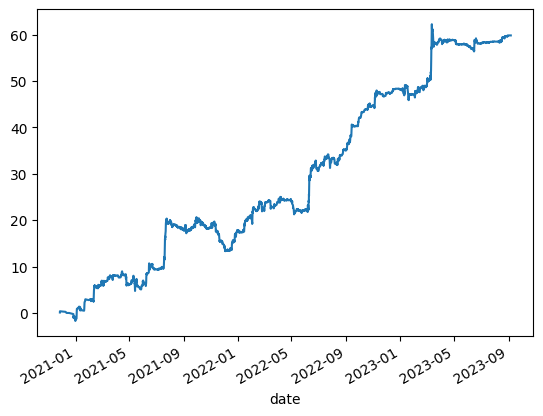

In [17]:
feature = 'delta_traded_demean_clipped'
tfilters = alldata.inuniv & (alldata[feature].abs()>6) #build alpha by selecting abs > 6, so we long top quantile and short bottom quantile signals with threshold abs 6
alldata[tfilters].groupby('date').apply(lambda x: (np.sign(x[feature])*x['fperf_168']).sum()).cumsum().plot() #pnl curve

avg positive weight: 0.0968828364692051
avg negative weight: -0.09288910319238008


,gmv,turnover,pnl,retptrade,SR
YQ,,,,,
2021Q1,0.11,0.16,12.85,115.33,3.09
2021Q2,0.09,0.11,1.27,14.83,0.52
2021Q3,0.07,0.17,5.21,60.48,3.45
2021Q4,0.08,0.13,-1.32,-14.33,-0.87
2022Q1,0.08,0.11,4.73,60.85,3.44
2022Q2,0.09,0.14,5.81,63.66,2.50
2022Q3,0.12,0.09,6.01,64.76,3.53
2022Q4,0.10,0.12,5.56,60.81,4.58
2023Q1,0.10,0.11,7.23,74.34,4.25


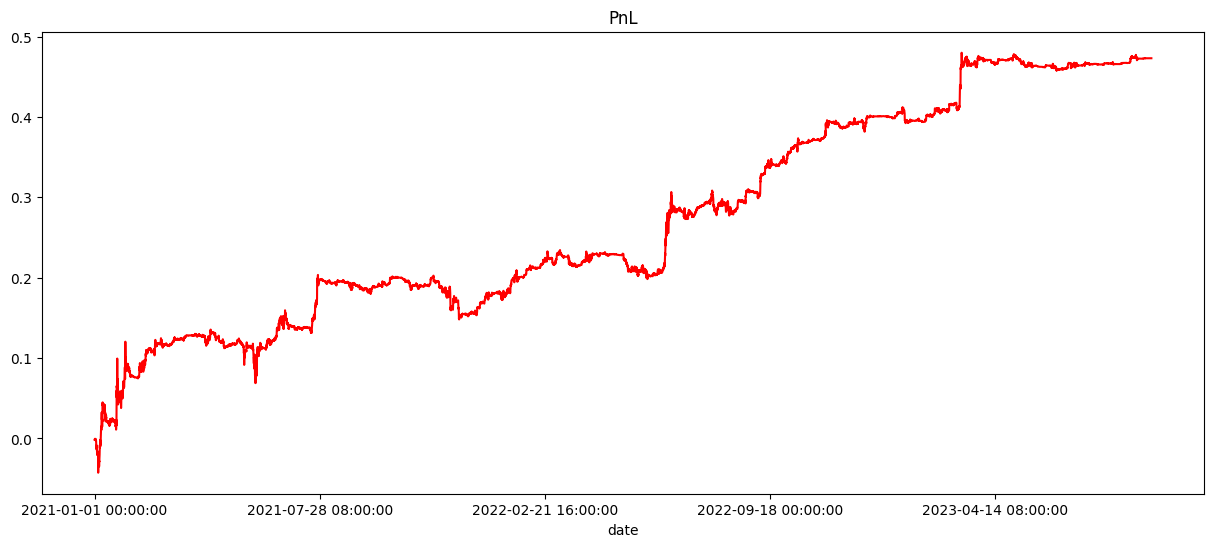

In [18]:
alldata['sig_deltatd'] = np.sign(alldata['delta_traded_demean_clipped']) * (alldata['delta_traded_demean_clipped'].abs()>6)
alldata['sig_deltatd_hp168'] = alldata['sig_deltatd'].rolling(window=168, min_periods=1).mean()
Franklin_Utility.pnldetails_crypto(alldata, 'sig_deltatd_hp168', ret_col='fret_60m', pct = False)

Above is backtest results, gmv is market value of the alpha, and turnover column shows the turnover rate of alpha. If turnover rate is too high, then it will impact retptrade which is return per trade, and causing more serious transaction cost problems. From trading perspective, we want an alpha that can at least cover 4bps transaction cost per trade. SR is sharpe ratio

# Part 2, machine learning for signal combinations

We have already had several signals, now we would like to combine the signals to improve performance using machine learning

tab_signals are loaded as below:

In [19]:
tab_signals = pd.read_parquet('/shared/data/tab_signals.parquet')

In [20]:
alldata = pd.read_parquet(r'/data/alldata/crypto_perpetual/alldata_hourly.parquet')

In [21]:
alldata = pd.merge(alldata, tab_signals, on=['date', 'symbol'], how='left')

In [22]:
tab_signals

,date,symbol,pos_MACD_cross,pos_RSI_24m12,pos_RSI,pos_WR,pos_BOLL_24m12,pos_BOLL,pos_MFI
0,2020-01-01 00:00:00,BCHUSDT,NaN,NaN,NaN,-0.228571,NaN,NaN,NaN
1,2020-01-01 00:00:00,BTCUSDT,NaN,NaN,NaN,0.119691,NaN,NaN,NaN
2,2020-01-01 00:00:00,ETHUSDT,NaN,NaN,NaN,-0.245614,NaN,NaN,NaN
3,2020-01-01 01:00:00,BCHUSDT,NaN,NaN,6.404078,-1.030541,NaN,NaN,NaN
4,2020-01-01 01:00:00,BTCUSDT,NaN,NaN,8.498189,7.700505,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3612977,2023-09-06 03:00:00,YGGUSDT,0.0,0.000000e+00,-0.000000,-3.794045,-0.896787,-1.694477,-0.0
3612978,2023-09-06 03:00:00,ZECUSDT,-1.0,0.000000e+00,-0.000000,-5.428768,-0.000000,-0.000000,-0.0
3612979,2023-09-06 03:00:00,ZENUSDT,0.0,9.251859e-18,-4.286826,-5.998239,-0.000000,-0.000000,-0.0
3612980,2023-09-06 03:00:00,ZILUSDT,0.0,-3.700743e-17,-0.000000,-3.439680,-0.000000,-0.000000,-0.0


In [23]:
alldata

,date,open_time,open,high,low,close,volume,close_time,usdt_volume,num_trades,...,fret_20m,fret_30m,fret_60m,pos_MACD_cross,pos_RSI_24m12,pos_RSI,pos_WR,pos_BOLL_24m12,pos_BOLL,pos_MFI
0,2020-01-01 00:00:00,2019-12-31 23:00:00,204.68000,205.34000,203.94000,204.72000,8197.200,2019-12-31 23:59:59.999,1.677446e+06,1106,...,0.006983,0.009327,0.009175,NaN,NaN,NaN,-0.228571,NaN,NaN,NaN
1,2020-01-01 00:00:00,2019-12-31 23:00:00,7195.04000,7199.98000,7179.26000,7189.00000,2037.547,2019-12-31 23:59:59.999,1.464969e+07,3152,...,0.000250,0.002197,0.003580,NaN,NaN,NaN,0.119691,NaN,NaN,NaN
2,2020-01-01 00:00:00,2019-12-31 23:00:00,128.95000,129.37000,128.80000,129.12000,16504.340,2019-12-31 23:59:59.999,2.130410e+06,1296,...,0.001016,0.006009,0.008291,NaN,NaN,NaN,-0.245614,NaN,NaN,NaN
3,2020-01-01 01:00:00,2020-01-01 00:00:00,204.72000,204.78000,203.60000,204.61000,7932.173,2020-01-01 00:59:59.999,1.620106e+06,1140,...,0.005026,0.003851,0.004379,NaN,NaN,6.404078,-1.030541,NaN,NaN,NaN
4,2020-01-01 01:00:00,2020-01-01 00:00:00,7189.43000,7190.52000,7170.15000,7171.55000,2449.049,2020-01-01 00:59:59.999,1.757642e+07,3688,...,0.004413,0.003543,0.003115,NaN,NaN,8.498189,7.700505,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612977,2023-09-06 03:00:00,2023-09-06 02:00:00,0.22540,0.22560,0.22420,0.22490,939786.000,2023-09-06 02:59:59.999,2.113247e+05,1201,...,NaN,NaN,NaN,0.0,0.000000e+00,-0.000000,-3.794045,-0.896787,-1.694477,-0.0
3612978,2023-09-06 03:00:00,2023-09-06 02:00:00,24.77000,24.79000,24.67000,24.77000,4209.424,2023-09-06 02:59:59.999,1.040780e+05,829,...,NaN,NaN,NaN,-1.0,0.000000e+00,-0.000000,-5.428768,-0.000000,-0.000000,-0.0
3612979,2023-09-06 03:00:00,2023-09-06 02:00:00,7.34900,7.36100,7.31900,7.35500,13187.600,2023-09-06 02:59:59.999,9.678230e+04,1195,...,NaN,NaN,NaN,0.0,9.251859e-18,-4.286826,-5.998239,-0.000000,-0.000000,-0.0
3612980,2023-09-06 03:00:00,2023-09-06 02:00:00,0.01645,0.01649,0.01639,0.01648,7659938.000,2023-09-06 02:59:59.999,1.258738e+05,817,...,NaN,NaN,NaN,0.0,-3.700743e-17,-0.000000,-3.439680,-0.000000,-0.000000,-0.0


avg positive weight: 18.85987583352495
avg negative weight: -18.758065969718817


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,36.45,0.33,60.38,60.38,7.94,2.79,2.79
2021Q2,41.89,0.36,61.35,61.35,9.48,1.78,1.78
2021Q3,39.51,0.36,1.76,1.76,-0.84,0.10,0.10
2021Q4,39.20,0.33,65.25,65.25,15.18,3.93,3.93
2022Q1,37.80,0.35,-15.85,-15.85,6.40,-0.97,-0.97
2022Q2,36.36,0.35,13.40,13.40,9.34,0.57,0.57
2022Q3,33.34,0.32,2.87,2.87,-1.14,0.22,0.22
2022Q4,30.57,0.32,13.23,13.23,6.52,0.99,0.99
2023Q1,32.96,0.32,-14.32,-14.32,1.20,-0.99,-0.99


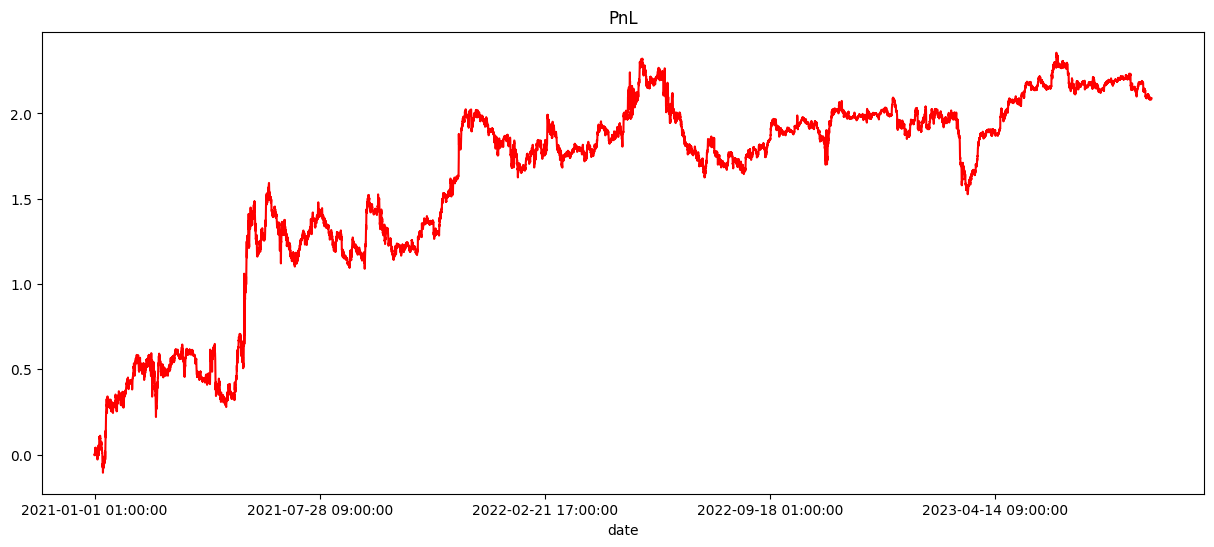

In [24]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_MACD_cross', ret_col='fret_60m')

avg positive weight: 7.172223879243083
avg negative weight: -6.665585638589723


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,10.87,0.19,35.15,35.15,16.98,1.43,1.43
2021Q2,13.03,0.20,151.13,151.13,48.10,5.20,5.20
2021Q3,13.23,0.20,-24.39,-24.39,4.51,-1.28,-1.28
2021Q4,14.33,0.19,64.85,64.85,30.79,4.30,4.30
2022Q1,15.74,0.20,29.34,29.34,11.28,1.78,1.78
2022Q2,14.13,0.20,62.82,62.82,34.11,2.51,2.51
2022Q3,14.61,0.20,36.77,36.77,14.10,2.63,2.63
2022Q4,13.78,0.18,7.41,7.41,3.87,0.54,0.54
2023Q1,14.31,0.19,4.61,4.61,11.94,0.33,0.33


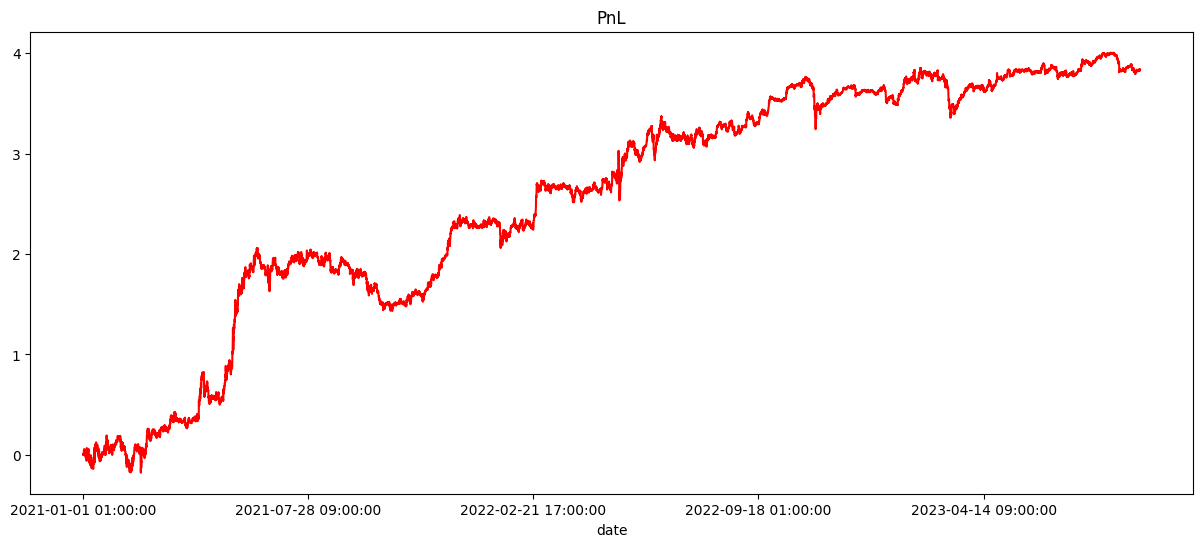

In [25]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_RSI_24m12', ret_col='fret_60m')

avg positive weight: 44.326870717129644
avg negative weight: -41.997884008138634


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,73.82,0.15,33.98,33.98,13.61,1.50,1.50
2021Q2,86.82,0.17,122.68,122.68,54.80,4.24,4.24
2021Q3,85.61,0.16,-11.06,-11.06,-0.20,-0.60,-0.60
2021Q4,86.49,0.15,54.78,54.78,26.28,3.92,3.92
2022Q1,87.81,0.16,27.76,27.76,17.15,1.71,1.71
2022Q2,86.50,0.17,54.32,54.32,22.93,2.34,2.34
2022Q3,85.69,0.17,26.96,26.96,11.62,2.04,2.04
2022Q4,85.69,0.15,6.85,6.85,4.35,0.51,0.51
2023Q1,86.06,0.16,0.77,0.77,1.38,0.06,0.06


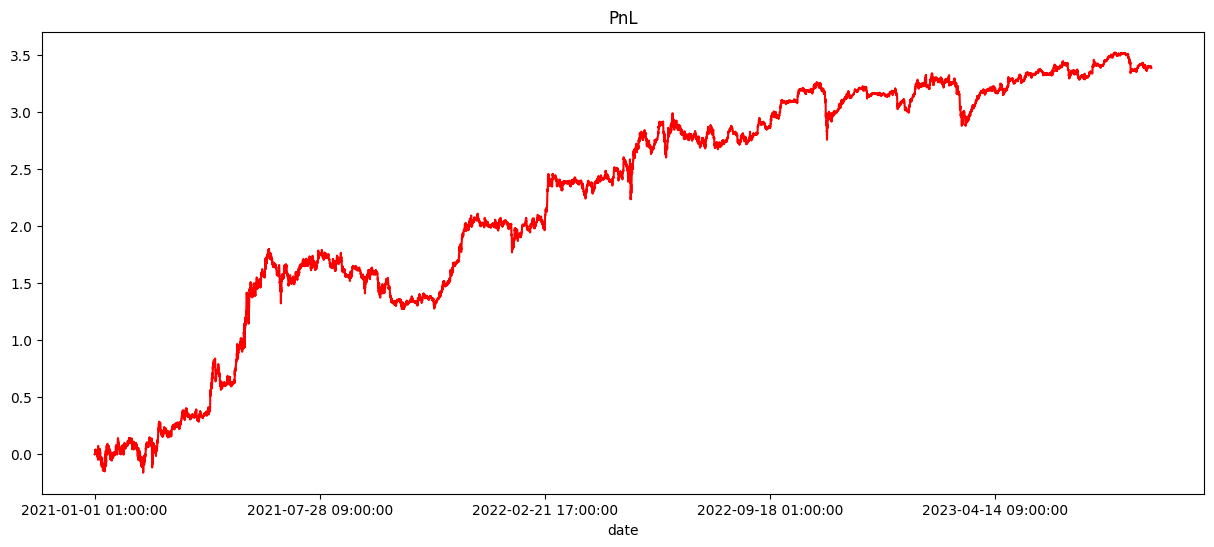

In [26]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_BOLL_24m12', ret_col='fret_60m')

avg positive weight: 53.260341280426275
avg negative weight: -46.778304663525475


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,83.54,0.78,122.46,122.46,11.55,3.84,3.84
2021Q2,93.20,0.82,-9.17,-9.17,11.57,-0.23,-0.23
2021Q3,83.64,0.79,26.40,26.40,9.67,1.04,1.04
2021Q4,83.06,0.77,67.33,67.33,5.27,3.01,3.01
2022Q1,91.93,0.76,-6.44,-6.44,-3.17,-0.31,-0.31
2022Q2,77.27,0.86,12.02,12.02,4.83,0.33,0.33
2022Q3,72.58,0.79,73.45,73.45,6.76,4.18,4.18
2022Q4,63.03,0.81,108.38,108.38,9.64,6.24,6.24
2023Q1,67.85,0.81,32.68,32.68,1.36,1.61,1.61


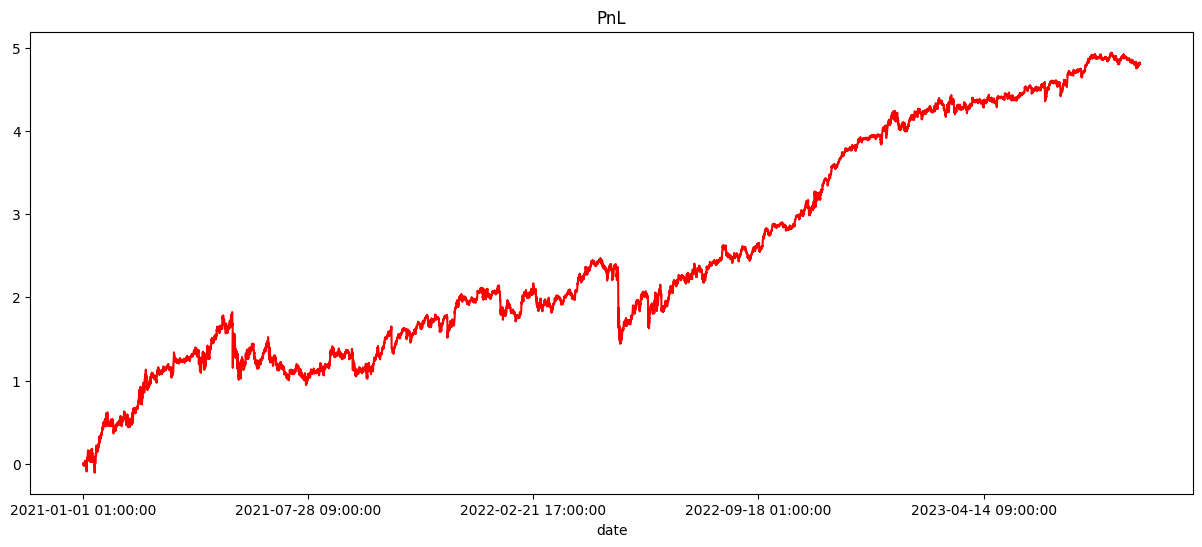

In [27]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_RSI', ret_col='fret_60m')

avg positive weight: 151.22807686546477
avg negative weight: -144.05385143827468


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,287.14,0.37,59.01,59.01,14.95,2.54,2.54
2021Q2,326.89,0.37,34.47,34.47,8.13,0.99,0.99
2021Q3,320.11,0.37,46.78,46.78,10.01,2.43,2.43
2021Q4,300.38,0.35,44.52,44.52,5.36,2.61,2.61
2022Q1,322.11,0.34,9.21,9.21,-1.00,0.56,0.56
2022Q2,302.08,0.36,45.05,45.05,8.42,1.89,1.89
2022Q3,287.36,0.36,76.48,76.48,11.61,5.76,5.76
2022Q4,275.05,0.34,-12.09,-12.09,1.17,-0.83,-0.83
2023Q1,274.42,0.34,12.41,12.41,1.54,0.92,0.92


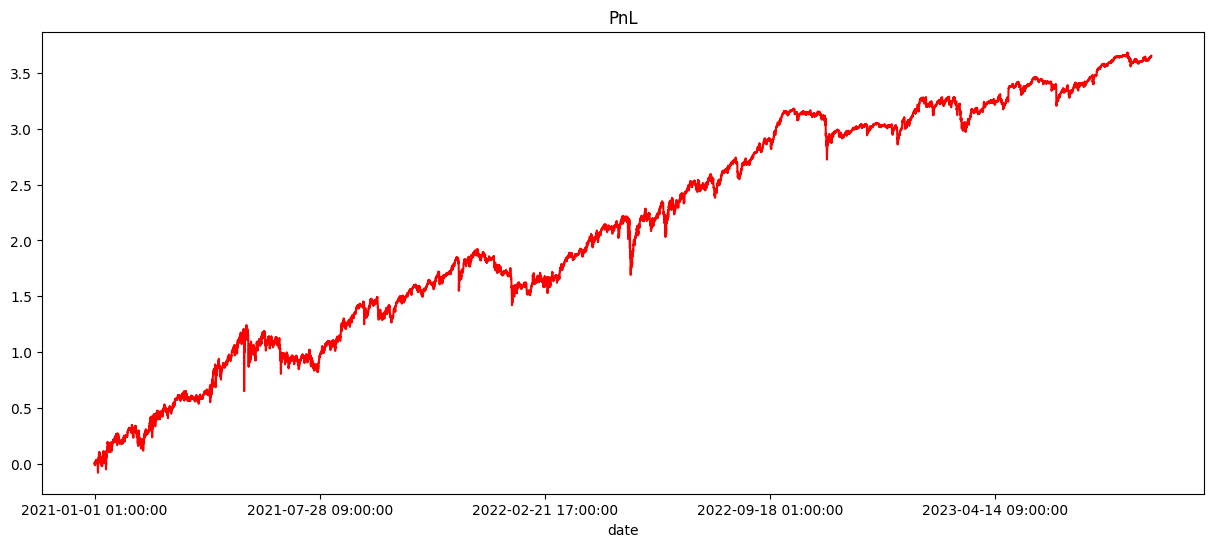

In [28]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_WR', ret_col='fret_60m')

avg positive weight: 55.80310403023182
avg negative weight: -52.82069476962004


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,93.23,0.49,69.09,69.09,12.64,2.91,2.91
2021Q2,108.40,0.51,-16.34,-16.34,7.91,-0.44,-0.44
2021Q3,108.00,0.51,68.19,68.19,9.64,3.52,3.52
2021Q4,108.90,0.49,47.54,47.54,6.87,2.73,2.73
2022Q1,109.87,0.48,21.76,21.76,-1.64,1.31,1.31
2022Q2,107.67,0.52,17.58,17.58,3.92,0.72,0.72
2022Q3,108.29,0.50,71.51,71.51,8.24,5.39,5.39
2022Q4,107.68,0.49,19.59,19.59,3.68,1.35,1.35
2023Q1,107.88,0.49,35.99,35.99,1.32,2.61,2.61


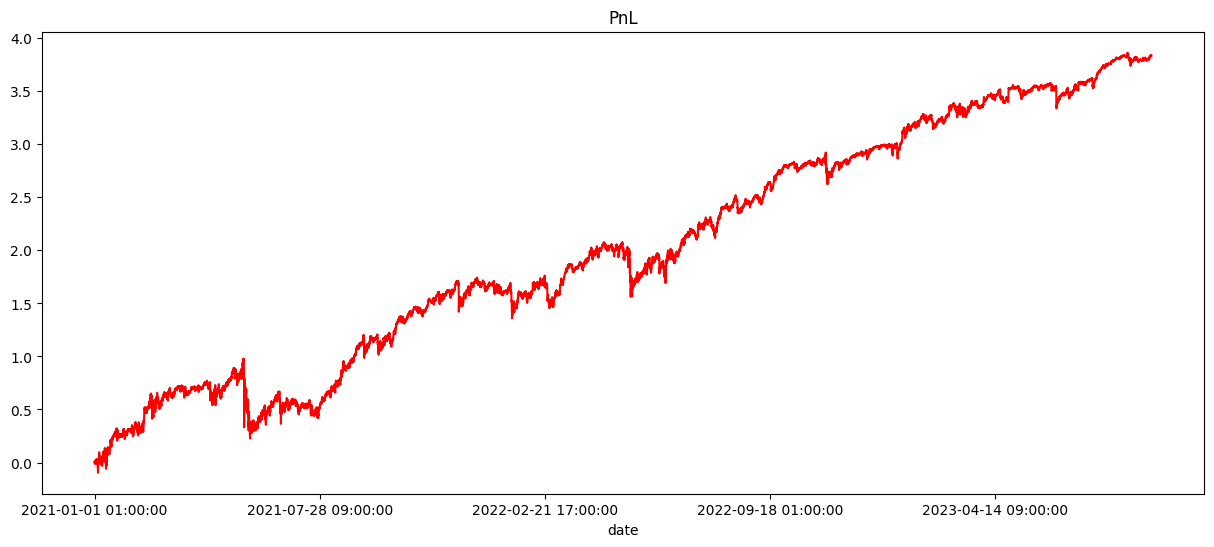

In [29]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_BOLL', ret_col='fret_60m')

avg positive weight: 3.5988125077610396
avg negative weight: -2.401976605098501


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,2.09,1.17,158.48,158.48,21.71,3.41,3.41
2021Q2,2.59,1.18,122.53,122.53,41.97,2.53,2.53
2021Q3,2.56,1.11,52.95,52.95,13.40,1.82,1.82
2021Q4,2.52,1.11,76.27,76.27,-4.20,1.92,1.92
2022Q1,3.13,1.12,51.88,51.88,3.41,2.28,2.28
2022Q2,2.63,1.19,177.66,177.66,12.86,3.68,3.68
2022Q3,2.52,1.19,150.22,150.22,5.63,5.99,5.99
2022Q4,2.19,1.22,109.54,109.54,6.68,3.75,3.75
2023Q1,3.07,1.16,157.67,157.67,7.13,5.79,5.79


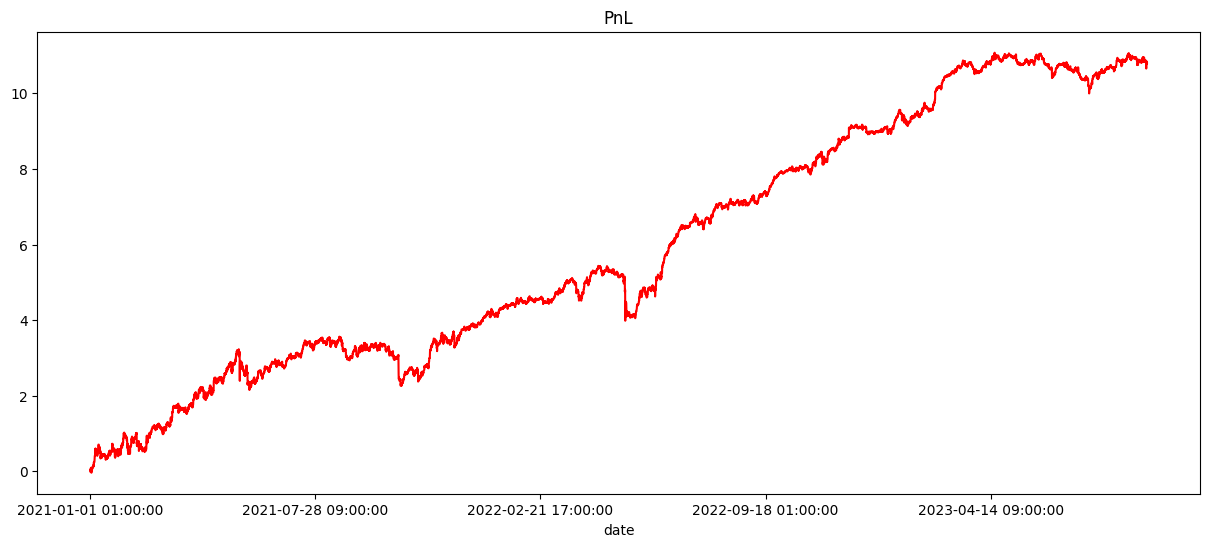

In [30]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_MFI', ret_col='fret_60m')

In [31]:
signalnames = ['MACD_cross', 'RSI_24m12', 'BOLL_24m12', 'RSI', 'WR', 'BOLL', 'MFI']

In [32]:
posnames = [f'pos_{signalname}' for signalname in signalnames]  # list comprehension

In [33]:
for signalname in signalnames:
    alldata[f'{signalname}_ret'] = alldata[f'pos_{signalname}'] * alldata['fret_60m'] 

In [34]:
signalrets = [f'{signalname}_ret' for signalname in signalnames]

<AxesSubplot:>

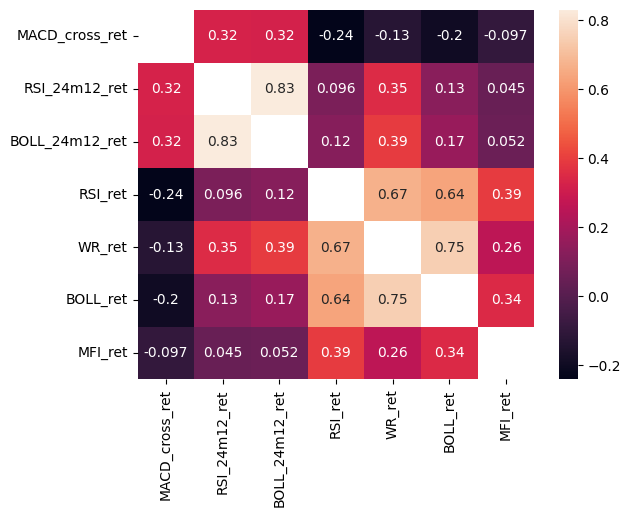

In [35]:
sns.heatmap(alldata[signalrets].corr().replace(1,np.nan), annot=True)

# in-sample and out-of-sample

In [36]:
alldata['IS'] = (alldata['date'] > '2021') & (alldata['date'] < '2022')
alldata['OS'] = (alldata['date'] > '2022')

### Equal volatility aggregated alphas

In [37]:
signalrets

['MACD_cross_ret',
 'RSI_24m12_ret',
 'BOLL_24m12_ret',
 'RSI_ret',
 'WR_ret',
 'BOLL_ret',
 'MFI_ret']

In [38]:
sig_vols = alldata[alldata.IS].groupby('date')[signalrets].sum().replace(0,np.nan).std() * np.sqrt(365*24)
sig_vols

MACD_cross_ret     49.005282
RSI_24m12_ret      17.255994
BOLL_24m12_ret     87.124334
RSI_ret           317.189408
WR_ret            454.990531
BOLL_ret          158.829174
MFI_ret            13.148748
dtype: float64

In [39]:
for signalname in signalnames:
    alldata[f'pos_{signalname}_norm'] = alldata[f'pos_{signalname}'] / sig_vols[f'{signalname}_ret']

In [40]:
signalrets_norm = [f'pos_{signalname}_norm' for signalname in signalnames]

In [41]:
signalrets_norm

['pos_MACD_cross_norm',
 'pos_RSI_24m12_norm',
 'pos_BOLL_24m12_norm',
 'pos_RSI_norm',
 'pos_WR_norm',
 'pos_BOLL_norm',
 'pos_MFI_norm']

In [42]:
alldata['signal_comb'] = 0
for signalname in signalnames:
    alldata['signal_comb'] += alldata[f'pos_{signalname}_norm'].fillna(0)

avg positive weight: 1.5295814816111435
avg negative weight: -1.471587230832405


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,2.66,0.37,84.92,84.92,17.56,3.65,3.65
2021Q2,3.04,0.38,133.49,133.49,26.83,3.84,3.84
2021Q3,3.07,0.37,27.96,27.96,8.95,1.44,1.44
2021Q4,3.13,0.35,69.32,69.32,14.70,4.22,4.22
2022Q1,3.29,0.35,19.91,19.91,4.59,1.24,1.24
2022Q2,3.01,0.37,83.53,83.53,15.37,3.61,3.61
2022Q3,2.96,0.36,53.96,53.96,10.58,4.07,4.07
2022Q4,2.89,0.34,25.49,25.49,6.21,1.88,1.88
2023Q1,3.00,0.35,32.08,32.08,4.20,2.36,2.36


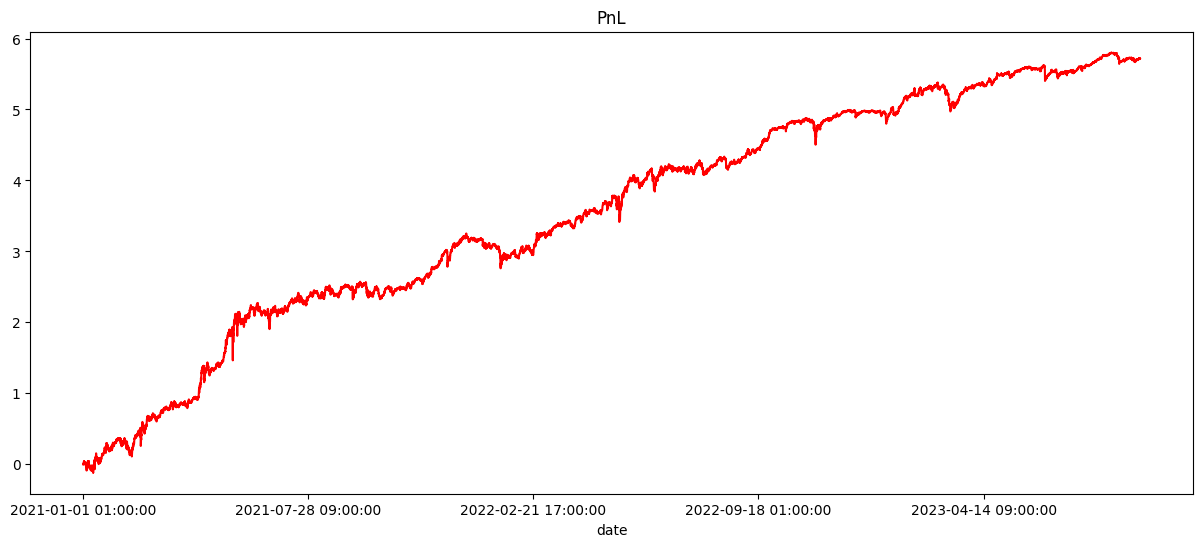

In [43]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'signal_comb', ret_col='fret_60m')

In [44]:
Franklin_Utility.gfun_df('gmv', alldata, 'signal_comb', 'date', lambda x: x.abs().sum(), cond=alldata.inuniv)
alldata['signal_comb_norm'] = alldata['signal_comb'] / alldata['gmv']

# 1. OLS regression

In [45]:
from sklearn.linear_model import LinearRegression, Lasso

In [46]:
lin = LinearRegression()
tab_res = None
tab_coef = pd.DataFrame(columns = signalnames)
training_window = 24 * 30
test_window = 24 * 7
dates = list(alldata.loc[alldata.date>'2021', 'date'].unique())
dates.sort()

In [47]:
for i in range(training_window, len(dates)-test_window+1, test_window):
    
    if i >= len(dates):
        break
        
    dates_train = dates[(i-training_window):i]
    dates_test = dates[i:min(i+test_window,len(dates))]
    datei = dates[i]
    print(datei, end='\r')
    
    train_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_train)), posnames + ['fret_60m']]
    X_train = train_roll.drop(columns = ['fret_60m'])
    y_train = train_roll['fret_60m']
    test_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_test)), ['date', 'symbol'] + posnames + ['fret_60m']]
    X_test = test_roll.drop(columns = ['date', 'symbol', 'fret_60m'])
    y_test = test_roll['fret_60m']
    lin.fit(X_train.fillna(0), y_train.fillna(0))
    y_pred = lin.predict(X_test.fillna(0))
    tab_datei = test_roll[['date', 'symbol']]
    tab_datei['y_pred'] = y_pred
    tab_coef.loc[datei] = lin.coef_
    
    if tab_res is None:
        tab_res = tab_datei
    else:
        tab_res = pd.concat([tab_res, tab_datei])

In [48]:
lin = LinearRegression()

In [49]:
lin.fit(X_train.fillna(0), y_train.fillna(0))
y_pred = lin.predict(X_test.fillna(0))

In [50]:
alldata = pd.merge(alldata, tab_res.rename(columns={'y_pred':'pos_OLS_noadj'}), on=['date', 'symbol'], how='left')

avg positive weight: 0.03334370149673294
avg negative weight: -0.03008952721233121


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,0.11,0.36,126.79,126.79,34.54,7.21,7.21
2021Q2,0.10,0.35,35.40,35.40,21.57,0.98,0.98
2021Q3,0.07,0.42,71.73,71.73,11.35,3.59,3.59
2021Q4,0.06,0.44,55.60,55.60,10.58,3.14,3.14
2022Q1,0.05,0.39,-30.57,-30.57,-4.73,-1.93,-1.93
2022Q2,0.07,0.35,46.38,46.38,10.63,2.02,2.02
2022Q3,0.05,0.41,26.21,26.21,3.08,1.95,1.95
2022Q4,0.04,0.44,32.84,32.84,4.29,2.85,2.85
2023Q1,0.05,0.32,-46.96,-46.96,-8.06,-3.20,-3.20


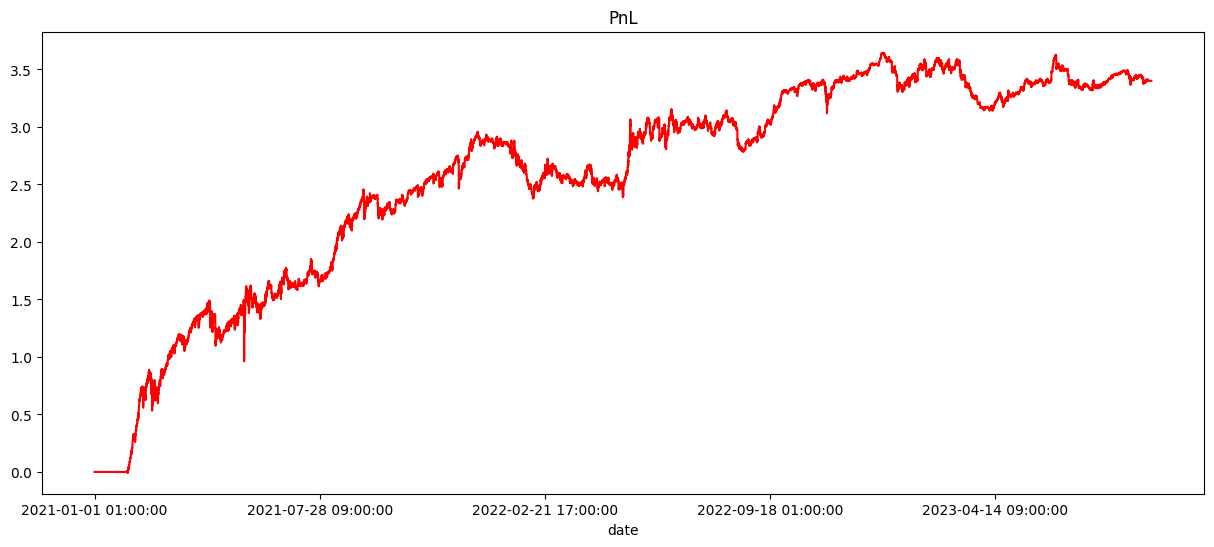

In [51]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_OLS_noadj', ret_col='fret_60m')

### 1.1 fix the return scaled by volatility

In [52]:
alldata['fret_60m_vol'] = alldata['fret_60m'] / alldata['vol'] #scale the future return by volatility

In [53]:
lin = LinearRegression()
tab_res = None
tab_coef = pd.DataFrame(columns = signalnames)
training_window = 24 * 30
test_window = 24 * 7
dates = list(alldata.loc[alldata.date>'2021', 'date'].unique())
dates.sort()

In [54]:
for i in range(training_window, len(dates)-test_window+1, test_window):
    
    if i >= len(dates):
        break
        
    dates_train = dates[(i-training_window):(i-1)]
    dates_test = dates[i:min(i+test_window,len(dates))]
    datei = dates[i]
    print(datei, end='\r')
    
    train_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_train)), posnames + ['fret_60m_vol']]
    X_train = train_roll.drop(columns = ['fret_60m_vol'])
    y_train = train_roll['fret_60m_vol']
    test_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_test)), ['date', 'symbol'] + posnames + ['fret_60m_vol']]
    X_test = test_roll.drop(columns = ['date', 'symbol', 'fret_60m_vol'])
    y_test = test_roll['fret_60m_vol']
    lin.fit(X_train.fillna(0), y_train.fillna(0))
    y_pred = lin.predict(X_test.fillna(0))
    tab_datei = test_roll[['date', 'symbol']]
    tab_datei['y_pred'] = y_pred
    tab_coef.loc[datei] = lin.coef_
    
    if tab_res is None:
        tab_res = tab_datei
    else:
        tab_res = pd.concat([tab_res, tab_datei])

In [55]:
alldata = pd.merge(alldata, tab_res.rename(columns={'y_pred':'pos_OLS'}), on=['date', 'symbol'], how='left')

avg positive weight: 2.439246809823884
avg negative weight: -2.516575384698482


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2021Q1,5.25,0.33,122.40,122.40,37.42,6.86,6.86
2021Q2,4.81,0.35,81.39,81.39,27.84,2.29,2.29
2021Q3,4.93,0.40,51.51,51.51,10.86,2.56,2.56
2021Q4,4.96,0.42,57.29,57.29,10.11,3.45,3.45
2022Q1,4.68,0.38,-24.04,-24.04,-4.88,-1.50,-1.50
2022Q2,5.51,0.32,43.08,43.08,13.80,1.86,1.86
2022Q3,4.24,0.38,19.44,19.44,3.84,1.43,1.43
2022Q4,4.56,0.44,44.86,44.86,4.66,4.01,4.01
2023Q1,5.34,0.29,-36.28,-36.28,-7.99,-2.49,-2.49


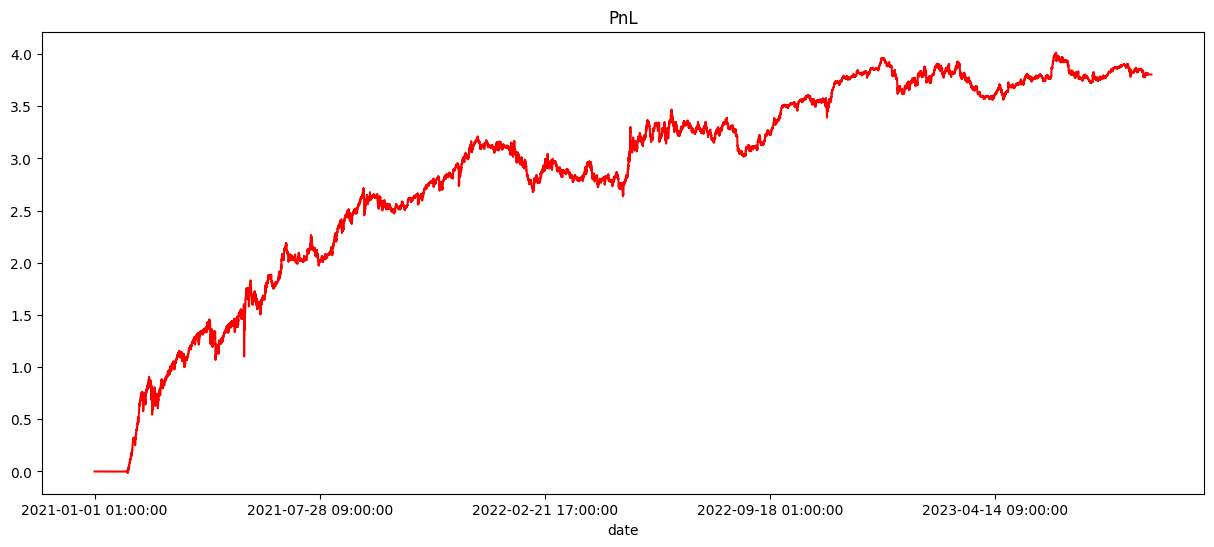

In [56]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2021'], 'pos_OLS', ret_col='fret_60m')

### Above is doing better, but still worse than equal volatility aggregated alphas

<AxesSubplot:>

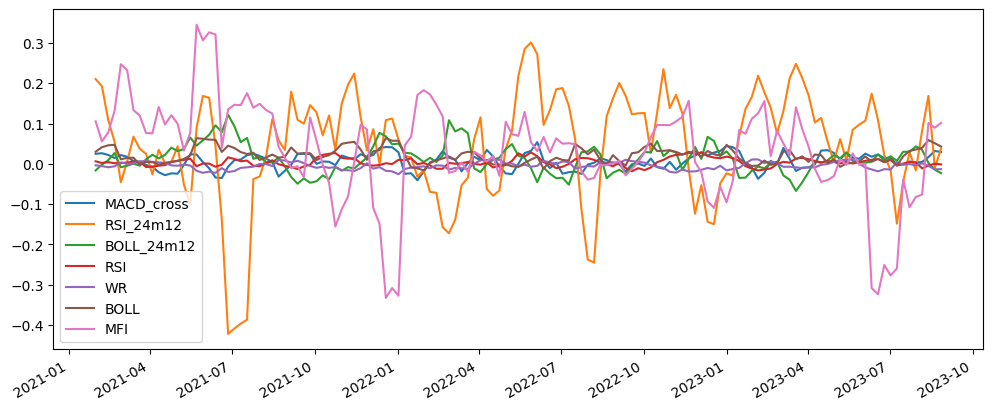

In [57]:
tab_coef.plot(figsize=(12,5)) #plot OLS coefficients

# 2. Lasso with cross-validation

In [58]:
# make window longer

In [59]:
lin = Lasso(alpha=1e-10, positive=True)
tab_res = None
tab_coef = pd.DataFrame(columns = signalnames)
min_training_window = 24 * 365
test_window = 24 * 7
dates = list(alldata.loc[alldata.date>'2021', 'date'].unique())
dates.sort()

In [60]:
for i in range(min_training_window, len(dates)-test_window+1, test_window):
    
    if i >= len(dates):
        break
        
    dates_train = dates[:(i-1)]
    dates_test = dates[i:min(i+test_window,len(dates))]
    datei = dates[i]
    print(datei, end='\r')
    
    train_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_train)), posnames + ['fret_60m_vol']]
    X_train = train_roll.drop(columns = ['fret_60m_vol'])
    y_train = train_roll['fret_60m_vol']
    test_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_test)), ['date', 'symbol'] + posnames + ['fret_60m_vol']]
    X_test = test_roll.drop(columns = ['date', 'symbol', 'fret_60m_vol'])
    y_test = test_roll['fret_60m_vol']
    lin.fit(X_train.fillna(0), y_train.fillna(0))
    y_pred = lin.predict(X_test.fillna(0))
    tab_datei = test_roll[['date', 'symbol']]
    tab_datei['y_pred'] = y_pred
    tab_coef.loc[datei] = lin.coef_
    
    if tab_res is None:
        tab_res = tab_datei
    else:
        tab_res = pd.concat([tab_res, tab_datei])

In [61]:
alldata = pd.merge(alldata, tab_res.rename(columns={'y_pred':'pos_Lasso_pos_1e-10_expand'}), on=['date', 'symbol'], how='left')

<AxesSubplot:>

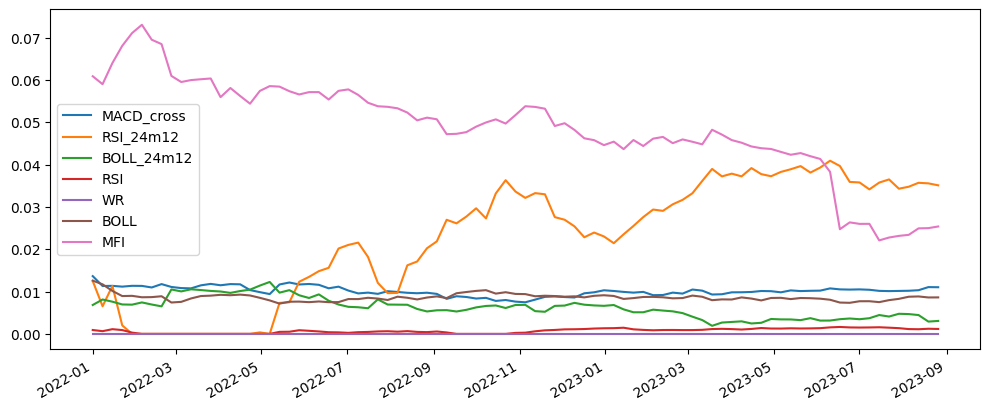

In [62]:
tab_coef.plot(figsize=(12,5))

avg positive weight: 1.6019085390983292
avg negative weight: -1.3918091820119505


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2022Q1,3.29,0.35,19.76,19.76,4.59,1.23,1.23
2022Q2,3.01,0.37,83.53,83.53,15.37,3.61,3.61
2022Q3,2.96,0.36,53.96,53.96,10.58,4.07,4.07
2022Q4,2.89,0.34,25.49,25.49,6.21,1.88,1.88
2023Q1,3.00,0.35,32.08,32.08,4.20,2.36,2.36
2023Q2,2.86,0.34,21.79,21.79,4.82,1.78,1.78
2023Q3,2.64,0.34,19.29,19.29,5.35,2.94,2.94
summary,2.96,0.35,148.59,148.59,7.45,2.51,2.51


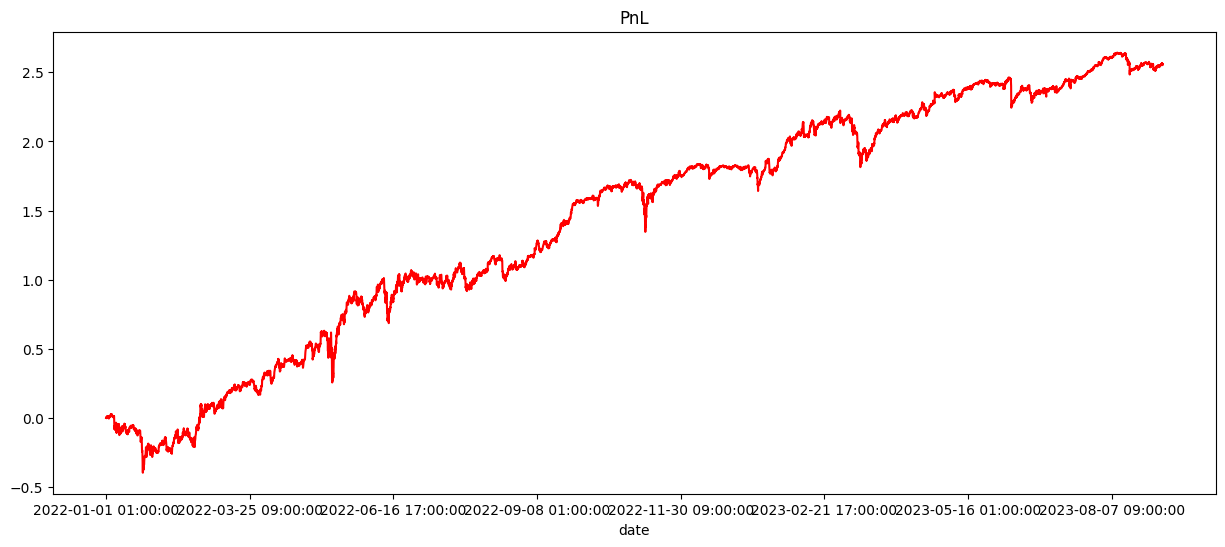

In [63]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2022'], 'signal_comb', ret_col='fret_60m')

In [64]:
from sklearn.model_selection import TimeSeriesSplit

## tune a Lasso Regression

In [65]:
alldata['fret_60m_vol'] = alldata['fret_60m_vol'].clip(-2,2)

In [66]:
dates_cv = list(alldata.loc[alldata.date.dt.year==2021, 'date'].unique())
dates_cv.sort()

### 1-year training window

In [67]:
from sklearn.metrics import r2_score

In [68]:
tscv = TimeSeriesSplit(n_splits=26, test_size=24*7)

In [69]:
for i, (index_cv_train, index_cv_test) in enumerate(tscv.split(dates_cv)):
    print(f"Fold {i}:")
    print(f"  Train: start={index_cv_train[0]}, end={index_cv_train[-1]}")
    print(f"  Test:  start={index_cv_test[0]}, end={index_cv_test[-1]}")

Fold 0:
  Train: start=0, end=4391
  Test:  start=4392, end=4559
Fold 1:
  Train: start=0, end=4559
  Test:  start=4560, end=4727
Fold 2:
  Train: start=0, end=4727
  Test:  start=4728, end=4895
Fold 3:
  Train: start=0, end=4895
  Test:  start=4896, end=5063
Fold 4:
  Train: start=0, end=5063
  Test:  start=5064, end=5231
Fold 5:
  Train: start=0, end=5231
  Test:  start=5232, end=5399
Fold 6:
  Train: start=0, end=5399
  Test:  start=5400, end=5567
Fold 7:
  Train: start=0, end=5567
  Test:  start=5568, end=5735
Fold 8:
  Train: start=0, end=5735
  Test:  start=5736, end=5903
Fold 9:
  Train: start=0, end=5903
  Test:  start=5904, end=6071
Fold 10:
  Train: start=0, end=6071
  Test:  start=6072, end=6239
Fold 11:
  Train: start=0, end=6239
  Test:  start=6240, end=6407
Fold 12:
  Train: start=0, end=6407
  Test:  start=6408, end=6575
Fold 13:
  Train: start=0, end=6575
  Test:  start=6576, end=6743
Fold 14:
  Train: start=0, end=6743
  Test:  start=6744, end=6911
Fold 15:
  Train: st

In [70]:
dates = np.array(dates)

In [71]:
tab_cv = pd.DataFrame(columns=['alpha_L1', 'avg_R2'])

for alpha_l1 in [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1, 10, 100]:
    
    print(alpha_l1)

    lin = Lasso(alpha=alpha_l1, positive=True)

    r2list = []
    for i, (index_cv_train, index_cv_test) in enumerate(tscv.split(dates_cv)):

        dates_cv_train = dates[index_cv_train]
        dates_cv_test = dates[index_cv_test]

        cv_train_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_cv_train)), posnames + ['fret_60m_vol']]
        X_cv_train = cv_train_roll.drop(columns = ['fret_60m_vol'])
        y_cv_train = cv_train_roll['fret_60m_vol']
        cv_test_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_cv_test)), ['date', 'symbol'] + posnames + ['fret_60m_vol']]
        X_cv_test = cv_test_roll.drop(columns = ['date', 'symbol', 'fret_60m_vol'])
        y_cv_test = cv_test_roll['fret_60m_vol']
        lin.fit(X_cv_train.fillna(0), y_cv_train.fillna(0))
        y_cv_pred = lin.predict(X_cv_test.fillna(0))
        ys_pred = pd.DataFrame({'y_cv_test':y_cv_test, 'y_cv_pred':y_cv_pred}).dropna()    #去掉NA
        r2_score_lasso = r2_score(ys_pred['y_cv_test'], ys_pred['y_cv_pred'])              # 次序不能搞错了！！！
        r2list.append(r2_score_lasso)

    avg_r2 = np.mean(r2list)
    print(f'alpha_L1:{alpha_l1}, R2:{avg_r2}')
    tab_cv.loc[len(tab_cv)] = [alpha_l1, avg_r2]

1e-10
alpha_L1:1e-10, R2:-0.0007443034255621556
1e-08
alpha_L1:1e-08, R2:-0.0007443013262988241
1e-06
alpha_L1:1e-06, R2:-0.0007440918146988662
0.0001
alpha_L1:0.0001, R2:-0.0007234622204366428
0.01
alpha_L1:0.01, R2:-0.001214142779479745
1
alpha_L1:1, R2:-0.002354090542619745
10
alpha_L1:10, R2:-0.002354090542619745
100
alpha_L1:100, R2:-0.002354090542619745


In [72]:
tab_cv

,alpha_L1,avg_R2
0,1.000000e-10,-0.000744
1,1.000000e-08,-0.000744
2,1.000000e-06,-0.000744
3,1.000000e-04,-0.000723
4,1.000000e-02,-0.001214
5,1.000000e+00,-0.002354
6,1.000000e+01,-0.002354
7,1.000000e+02,-0.002354


In [73]:
lin = Lasso(alpha=1e-4, positive=True)
tab_res = None
tab_coef = pd.DataFrame(columns = signalnames)
training_window = 24 * 365
test_window = 24 * 7
dates = list(alldata.loc[alldata.date>'2021', 'date'].unique())
dates.sort()

In [74]:
for i in range(training_window, len(dates)-test_window+1, test_window):
    
    if i >= len(dates):
        break
        
    dates_train = dates[(i-training_window):(i-1)]
    dates_test = dates[i:min(i+test_window,len(dates))]
    datei = dates[i]
    print(datei, end='\r')
    
    train_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_train)), posnames + ['fret_60m_vol']]
    X_train = train_roll.drop(columns = ['fret_60m_vol'])
    y_train = train_roll['fret_60m_vol']
    test_roll = alldata.loc[alldata.inuniv&(alldata['date'].isin(dates_test)), ['date', 'symbol'] + posnames + ['fret_60m_vol']]
    X_test = test_roll.drop(columns = ['date', 'symbol', 'fret_60m_vol'])
    y_test = test_roll['fret_60m_vol']
    lin.fit(X_train.fillna(0), y_train.fillna(0))
    y_pred = lin.predict(X_test.fillna(0))
    tab_datei = test_roll[['date', 'symbol']]
    tab_datei['y_pred'] = y_pred
    tab_coef.loc[datei] = lin.coef_
    
    if tab_res is None:
        tab_res = tab_datei
    else:
        tab_res = pd.concat([tab_res, tab_datei])

<AxesSubplot:>

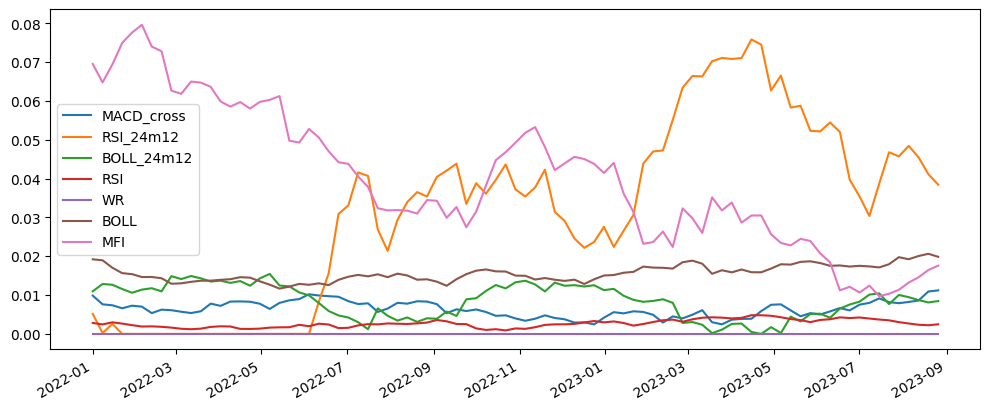

In [75]:
tab_coef.plot(figsize=(12,5))

In [76]:
alldata = pd.merge(alldata, tab_res.rename(columns={'y_pred':'pos_Lasso_pos_1e-4_expand'}), on=['date', 'symbol'], how='left')

avg positive weight: 0.982980667235898
avg negative weight: -1.4584235310760683


,gmv,turnover,pnl(%),pnl_ac(%),retptrade,SR,SR_ac
YQ,,,,,,,
2022Q1,2.40,0.46,4.78,4.78,-1.54,0.28,0.28
2022Q2,1.99,0.49,109.99,109.99,12.24,4.59,4.59
2022Q3,2.19,0.47,78.33,78.33,9.61,5.65,5.65
2022Q4,2.51,0.39,66.49,66.49,8.35,4.90,4.90
2023Q1,2.71,0.42,29.31,29.31,-0.89,2.12,2.12
2023Q2,2.49,0.45,35.65,35.65,4.14,2.88,2.88
2023Q3,2.48,0.46,24.84,24.84,5.57,3.88,3.88
summary,2.39,0.45,204.24,204.24,5.12,3.33,3.33


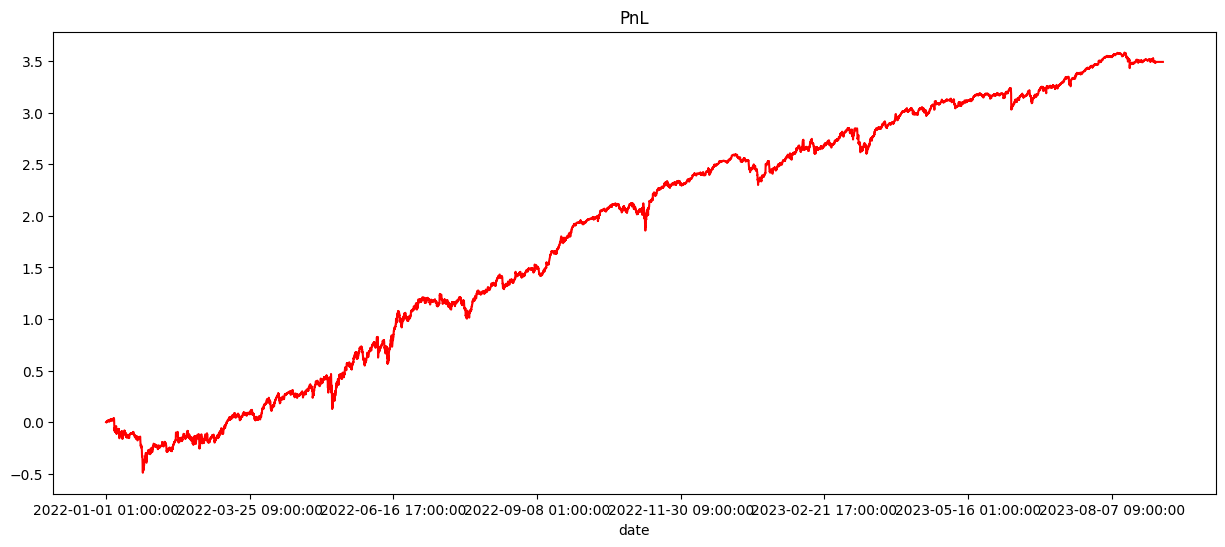

In [77]:
Franklin_Utility.pnldetails_crypto(alldata.loc[alldata.date>'2022'], 'pos_Lasso_pos_1e-4_expand', ret_col='fret_60m')